## Import libraries ##

In [28]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

# analog data assimilation
import sys
sys.path.insert(0, '~/Dropbox/Documents/Codes/Python/AnDA_CME')
from AnDA_codes.AnDA_generate_data import AnDA_generate_data
from AnDA_codes.AnDA_analog_forecasting import AnDA_analog_forecasting
from AnDA_codes.AnDA_optimize_number_analogs import optimize_nb_analogs
from AnDA_codes.AnDA_model_forecasting import AnDA_model_forecasting
from AnDA_codes.AnDA_data_assimilation import AnDA_data_assimilation
from AnDA_codes.AnDA_stat_functions import AnDA_RMSE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


## Functions to compute model evidence ##

In [29]:
def mooving_average(x, N):
    out = np.zeros_like(x, dtype=np.float64)
    dim_len = x.shape[0]
    for i in range(dim_len):
        if N%2 == 0:
            a, b = i - (N-1)//2, i + (N-1)//2 + 2
        else:
            a, b = i - (N-1)//2, i + (N-1)//2 + 1

        #cap indices to min and max indices
        a = max(0, a)
        b = min(dim_len, b)
        out[i] = np.mean(x[a:b])
    return out

def model_evidence(ll_good, ll_bad, K, yo):
    out = np.sum((mooving_average(ll_good-ll_bad,K)>0)/len(yo.time)*100)
    return out

## Example ##
Definition of the good catalog, the associated analog forcasting class and optimize the number of analog for the good catalog.

In [30]:
K = 1000 # maximum size of the evidence window
optim_nb_analogs = True
dt_states = 1 # number of integration times between consecutive states (for xt and catalog)
dt_obs = 4 # number of integration times between consecutive observations (for yo)

In [31]:
K = 1000 # maximum size of the evidence window
optim_nb_analogs = True
# parameters
class GD:
    model = 'Lorenz_96'
    class parameters:
        F = 8
        J = 40
    dt_integration = 0.05 # integration time
    dt_states = dt_states # number of integration times between consecutive states (for xt and catalog)
    dt_obs = dt_obs # number of integration times between consecutive observations (for yo)
    var_obs = [17,18,19,20,21] # indices of the observed variables
    nb_loop_train = 500 # size of the catalog
    nb_loop_test = 500 # size of the true state and noisy observations
    sigma2_catalog = 0.001 # variance of the model error to generate the catalog   
    sigma2_obs = 1 # variance of the observation error to generate observations    
# run the data generation
catalog_good, xt, yo = AnDA_generate_data(GD)

# keep only a subset of variables
catalog_good.analogs = catalog_good.analogs[:,17:22]
catalog_good.successors = catalog_good.successors[:,17:22]
yo.values = yo.values[:,17:22]
n = catalog_good.analogs.shape[1]
global_analog_matrix=np.ones([n,n])

# parameters of the analog forecasting method
class AF:
    k = 50 # number of analogs
    neighborhood = global_analog_matrix
    catalog = catalog_good # catalog with analogs and successors
    regression = 'local_linear' # chosen regression ('locally_constant', 'increment', 'local_linear')
    sampling = 'gaussian' # chosen sampler ('gaussian', 'multinomial')
    kernel = "tricube"
    kdt=None
    initialized=False
#    global_linear=None

if optim_nb_analogs:
    nb_analogs = [50,100,200,300,400]
    res_good = optimize_nb_analogs(AF,nb_analogs=nb_analogs,verbose=True)
    print("Best nb analogs (5 components)", res_good["k_best"])
    m_tmp = np.mean(res_good["rmse"][2,:,:],axis=1)
    print("Best nb analogs (component 19)",nb_analogs[np.where(m_tmp==np.min(m_tmp))[0][0]])
    AF.k = res_good["k_best"]

Fold  0 / 5
   nb_analogs =  50
   nb_analogs =  100
   nb_analogs =  200
   nb_analogs =  300
   nb_analogs =  400
Fold  1 / 5
   nb_analogs =  50
   nb_analogs =  100
   nb_analogs =  200
   nb_analogs =  300
   nb_analogs =  400
Fold  2 / 5
   nb_analogs =  50
   nb_analogs =  100
   nb_analogs =  200
   nb_analogs =  300
   nb_analogs =  400
Fold  3 / 5
   nb_analogs =  50
   nb_analogs =  100
   nb_analogs =  200
   nb_analogs =  300
   nb_analogs =  400
Best nb analogs (5 components) 300
Best nb analogs (component 19) 200


In [32]:
AF.k = res_good["k_best"]
# parameters of the filtering method
class DA:
    method = 'AnEnKF' # chosen method ('AnEnKF', 'AnEnKS', 'AnPF')
    N = 100 # number of members (AnEnKF/AnEnKS) or particles (AnPF)
    xb = xt.values[0,17:22]; B = 0.1*np.eye(n)
    H = np.eye(n)
    R = GD.sigma2_obs*np.eye(n)
    @staticmethod
    def m(x):
        return AnDA_analog_forecasting(x,AF)
# run the analog data assimilation
x_hat_analog_good = AnDA_data_assimilation(yo, DA)

# loop on F values
F_values = array([7,9,10])
N_iter = 1
tab_ME_AnDA = zeros([N_iter,len(F_values),K])
for i_iter in range(N_iter):
    print(i_iter)
    for i_F in range(len(F_values)):
        print(F_values[i_F])
        # parameters
        class GD:
            model = 'Lorenz_96'
            class parameters:
                F = F_values[i_F]
                J = 40
            dt_integration = 0.05 # integration time
            dt_states = dt_states # number of integration times between consecutive states (for xt and catalog)
            dt_obs = dt_obs # number of integration times between consecutive observations (for yo)
            var_obs = [17,18,19,20,21] # indices of the observed variables
            nb_loop_train = 500 # size of the catalog
            nb_loop_test = 500 # size of the true state and noisy observations
            sigma2_catalog = 0.001 # variance of the model error to generate the catalog   
            sigma2_obs = 1 # variance of the observation error to generate observations    
        # run the data generation
        catalog_bad, tej1, tej2 = AnDA_generate_data(GD)
        # keep only a subset of variables
        catalog_bad.analogs = catalog_bad.analogs[:,17:22]
        catalog_bad.successors = catalog_bad.successors[:,17:22]
        # parameters of the analog forecasting method
        class AF:
            k = 50 # number of analogs
            neighborhood = global_analog_matrix
            catalog = catalog_bad # catalog with analogs and successors
            regression = 'local_linear' # chosen regression ('locally_constant', 'increment', 'local_linear')
            sampling = 'gaussian' # chosen sampler ('gaussian', 'multinomial')
            kernel = 'tricube'
            kdt=None
            initialized=False
        if optim_nb_analogs:
            res_bad = optimize_nb_analogs(AF,verbose=True)
            print("Best nb analogs", res_bad["k_best"])
            AF.k = res_bad["k_best"]        # parameters of the filtering method
            m_tmp = np.mean(res_good["rmse"][2,:,:],axis=1)
            print("Best nb analogs (component 19)",nb_analogs[np.where(m_tmp==np.min(m_tmp))[0][0]])

        class DA:
            method = 'AnEnKF' # chosen method ('AnEnKF', 'AnEnKS', 'AnPF')
            N = 100 # number of members (AnEnKF/AnEnKS) or particles (AnPF)
            xb = xt.values[0,17:22]; B = 0.1*np.eye(n)
            H = np.eye(n)
            R = GD.sigma2_obs*np.eye(n)
            @staticmethod
            def m(x):
                return AnDA_analog_forecasting(x,AF)
        # run the analog data assimilation
        x_hat_analog_bad = AnDA_data_assimilation(yo, DA)
        # compute model evidence
        ME_AnDA = zeros(K)
        for k in range(K):
            ME_AnDA[k] = model_evidence(x_hat_analog_good.loglik, x_hat_analog_bad.loglik, k, yo)
        # stock results
        tab_ME_AnDA[i_iter,i_F,:] = ME_AnDA

 23%|██▎       | 2346/10000 [02:39<08:40, 14.69it/s]


KeyboardInterrupt: 

In [18]:
tab_ME_AnDA

array([[[  0.  ,  64.38,  68.05, ..., 100.  , 100.  , 100.  ],
        [  0.  ,  45.11,  43.08, ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,  49.06,  47.94, ...,   0.  ,   0.  ,   0.  ]]])

## Plot results ##

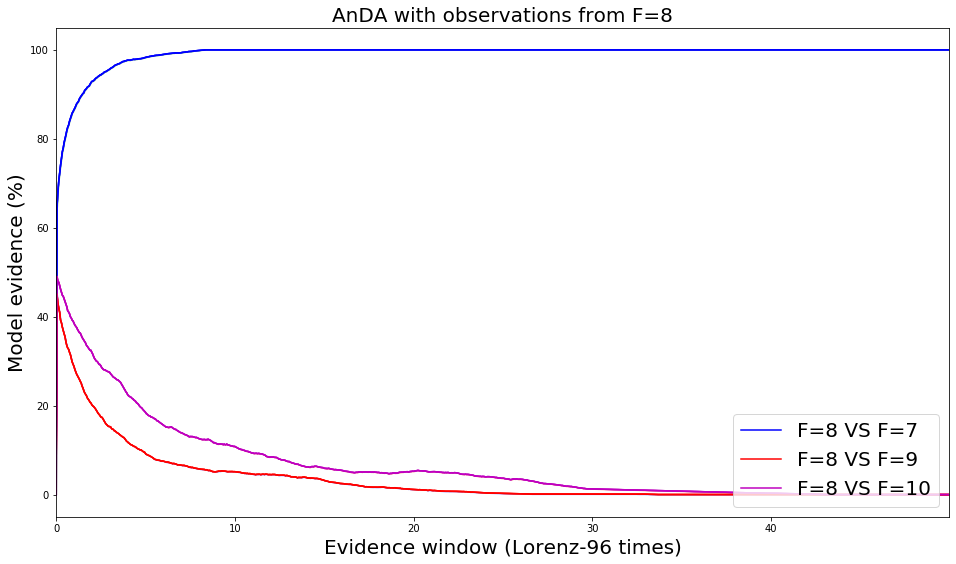

In [19]:
# plot model evidence as a function of evidence window
for i_F in range(len(F_values)):
    line3, = plot(yo.time[0:K], mean(tab_ME_AnDA[:,0,:], 0), 'b')
    line4, = plot(yo.time[0:K], mean(tab_ME_AnDA[:,1,:], 0), 'r')
    line5, = plot(yo.time[0:K], mean(tab_ME_AnDA[:,2,:], 0), 'm')
    fill_between(yo.time[0:K], percentile(tab_ME_AnDA[:,0,:], 5, axis=0), percentile(tab_ME_AnDA[:,0,:], 95, axis=0),
                 color='g', alpha=.1)
    fill_between(yo.time[0:K], percentile(tab_ME_AnDA[:,1,:], 5, axis=0), percentile(tab_ME_AnDA[:,1,:], 95, axis=0),
                 color='b', alpha=.1)
    fill_between(yo.time[0:K], percentile(tab_ME_AnDA[:,2,:], 5, axis=0), percentile(tab_ME_AnDA[:,2,:], 95, axis=0),
                 color='r', alpha=.1)
                
    xlim([yo.time[0],yo.time[K-1]])
    ylim([-5,105])
    legend([line3, line4, line5], ['F=8 VS F=7', 'F=8 VS F=9', 'F=8 VS F=10'], prop={'size': 20}, loc=4)
    xlabel('Evidence window (Lorenz-96 times)', size=20)
    ylabel('Model evidence (%)', size=20)
    title('AnDA with observations from F=8', size=20)
    #savefig('/home/ptandeo/Dropbox/Documents/Figures/AnDA_model_evidence/model_evidence_F_6to10.png', bbox_inches='tight', dpi=400)